In [56]:
import numpy as np
import pandas as pd
import glob
import random

In [57]:
from geopy import distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print (distance.geodesic(coords_1, coords_2).km)

279.35290160430094


In [108]:
trippath =r'E:\Data\Trainingdata\tripsample'
# trippath = r'E:\Data\test\trip'
Trip_file = glob.glob(trippath + "/*.txt")
logpath =r'E:\Data\Trainingdata\logsample'
# logpath = r'E:\Data\test\log'
Log_file = glob.glob(logpath + "/*.txt")

records = np.empty(shape=[0, 4200])
labels = np.empty(shape=[0])

def preprocess(df):
#     print(df)

    ## Time ##
    df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %X")
    df.sort_values(by='Time', inplace=True, ascending=True)
    df['Timedif'] = df['Time'] - df['Time'].shift(1)
    df['Timedif'] = df['Timedif'].astype(np.int64) // 10 ** 9.
    df = df.drop(['Time'], axis=1)
    df = df.reset_index(drop=True)
    df.iloc[0]['Timedif'] = 0
    df.iloc[0]['Timedif'] = np.mean(df['Timedif'])

    
    ## Distance ##
    coords = (df['Lat'], df['Lon'])
#     print(coords)
    lat = coords[0]
    lon = coords[1]
    distdif = []
    for i in range(0, len(lat) - 1):
#         print(distance.geodesic((lat[i], lon[i]), (lat[i + 1], lon[i + 1])).km)
        distdif.append(distance.geodesic((lat[i], lon[i]), (lat[i + 1], lon[i + 1])).km)
    mean = np.mean(distdif)
    distdif.insert(0, mean)
    df['Distdif'] = distdif
#     print(df['Distdif'])
    
    
    ## Speed ##
    speed = []
    timedif = df['Timedif']
#     print(source)
    for i in range(1, len(timedif)):
        speed.append(distdif[i] / timedif[i])
#     print(np.shape(speed))
    mean = np.mean(speed)
    speed.insert(0, mean)
    df['Speed'] = speed
    
    
    ## Flag ## - 2 diff source will return 1, same source returns 0
    flag = []
    source = df['Source']
#     print(source)
    flag.append(0) # adding 0 to the first value
    for i in range(len(source) - 1):
        if source[i] != source[i + 1]:
            flag.append(1)
        else:
            flag.append(0)
#     print(np.shape(flag))
    df['Flag'] = flag
    
    
#     print(df)
    ## Normalizing ##
    max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    df['Lat'] = df[['Lat']].apply(max_min_scaler)
    df['Lon'] = df[['Lon']].apply(max_min_scaler)
    df['Timedif'] = df[['Timedif']].apply(max_min_scaler)    
#     df['Distdif'] = df[['Distdif']].apply(max_min_scaler)
#     df['Speed'] = df[['Speed']].apply(max_min_scaler)


    ## Reshaping ##
    out = df.values.reshape(1, 4200)
    return out


################merging trajectories from two datasets######################
# for tripfile in Trip_file:
#     # if records.shape[0] > 1:
#     #     break
#     df1 = pd.read_csv(tripfile, usecols=[1, 2, 3, 4], sep=' ')
#     idx = 0
#     rand = random.randint(0, 4)
#     while rand == idx:
#         rand = random.randint(0, 4)
#     combine = 0
#     for logfile in Log_file:
#         if tripfile.replace(trippath, '') == logfile.replace(logpath,''):
#             df2 = pd.read_csv(logfile, usecols=[1,2,3,4], sep=' ')
#             combine = combine + 1
#             out = preprocess(pd.concat([df1, df2]))
#                 ######  test if there are nan or infinite values  ######
#                 # flag = False
#                 # for item in out:
#                 #     if np.any(np.isnan(item)) or ((not(np.all(np.isfinite(item))))):
#                 #         flag = True
#                 #         print(tripfile)
#     #             print(idx)
#             records = np.row_stack((records, out))
#             labels = np.append(labels, 1)
#             if idx == rand:
#                 idx = idx - 1
# #                 df2 = pd.read_csv(Log_file[idx], usecols=[1,2,3,4], sep=' ')
# #                 out = preprocess(pd.concat([df1, df2]))
# #                 records = np.row_stack((records, out))
# #                 labels = np.append(labels, 0)
# #                 combine = combine + 1
#         else:
#             if idx == rand:
#                 df2 = pd.read_csv(logfile, usecols=[1,2,3,4], sep=' ')
#                     #data = pd.concat([data, df])
#                 combine = combine + 1
#                 out = preprocess(pd.concat([df1, df2]))
#                 records = np.row_stack((records, out))
#                 labels = np.append(labels, 0)
#                     ##### test if there are nan or infinite values  ######
#                     # flag = False
#                     # for item in out:
#                     #     if np.any(np.isnan(item)) or ((not(np.all(np.isfinite(item))))):
#                     #         flag = True
#                     #         print(tripfile,logfile)
#                     # if flag: print(out)
#                 print(logfile, tripfile)
#         print(idx, rand, combine)
#         if combine >= 2:
#             break
#         idx = idx + 1
index = 0
while index < len(Trip_file):
    ## same ##
    df1 = pd.read_csv(Trip_file[index], usecols=[1, 2, 3, 4], sep=' ')
    df2 = pd.read_csv(Log_file[index], usecols=[1,2,3,4], sep=' ')
    out = preprocess(pd.concat([df1, df2]))
    records = np.row_stack((records, out))
    labels = np.append(labels, 1)
    
    ## different ##
    rand = random.randint(0, len(Trip_file) - 1)
    while rand == index:
        rand = random.randint(0, len(Trip_file) - 1)
    df3 = pd.read_csv(Log_file[rand], usecols=[1,2,3,4], sep=' ')
    out = preprocess(pd.concat([df1, df3]))
    records = np.row_stack((records, out))
    labels = np.append(labels, 0)
    index = index + 1

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: in

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divid

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inval

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: di

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: di

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divid

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inval

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: in

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: in

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: in

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: in

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: in

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: di

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inva

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: div

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: d

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: di

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divi

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: inv

C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lihao.A-I2R\AppData\Local\Continuum\anaconda3\envs\conda3.7\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: di

In [109]:
print(records)

[[6.01973614e-01 6.61871301e-01 1.00000000e+00 ... 4.84022142e+00
  1.06285055e-03 1.00000000e+00]
 [5.76696008e-01 5.80564361e-01 1.00000000e+00 ... 1.10099882e+01
  1.40864742e-03 0.00000000e+00]
 [6.35818521e-01 5.75988739e-01 1.00000000e+00 ... 8.39246289e+00
  2.99623809e-03 1.00000000e+00]
 ...
 [6.26558436e-01 6.65660532e-01 0.00000000e+00 ... 1.14474874e+01
  3.75081499e-03 1.00000000e+00]
 [3.29939548e-01 6.44605409e-01 1.00000000e+00 ... 1.27315099e+01
  5.66852621e-03 1.00000000e+00]
 [5.10064841e-01 9.83928205e-01 1.00000000e+00 ... 4.91598095e+00
  1.91283305e-03 1.00000000e+00]]


In [110]:
records.shape

(5974, 4200)

In [111]:
labels

array([1., 0., 1., ..., 0., 1., 0.])

In [114]:
np.savetxt('records4200.txt', records, delimiter=',')
np.savetxt('labels4200', labels, delimiter=',')

In [249]:
speed1 = []
speed0 = []


# print(records[0].shape)
# len(viewRecords)
for i in range(len(records)):
    if labels[i] == 1:
        speed1.append(records[i])
    else:
        speed0.append(records[i])

print(len(speed1), len(speed0))
# records.plot(kind="scatter", x="Timedif", y="Speed", alpha=0.1)

2987 2987


In [297]:
speed0 = np.asarray(speed0)
speed1 = np.asarray(speed1)
speed0 = speed0.reshape((1792200, 7))
speed1 = speed1.reshape((1792200, 7))
print(speed1)

[[6.01973614e-01 6.61871301e-01 1.00000000e+00 ... 8.29192558e+00
             nan 0.00000000e+00]
 [6.27506980e-01 6.02797420e-01 0.00000000e+00 ... 3.24830298e+00
  3.50788659e-03 1.00000000e+00]
 [6.21198235e-01 6.86254516e-01 0.00000000e+00 ... 4.20288265e+00
  6.36800401e-03 0.00000000e+00]
 ...
 [7.62275957e-01 3.57964834e-01 1.00000000e+00 ... 4.18328016e+00
  4.09162770e-04 1.00000000e+00]
 [2.95153251e-01 3.10035633e-01 1.00000000e+00 ... 9.91026402e+00
  1.24033342e-03 0.00000000e+00]
 [4.72107328e-01 6.29826509e-01 0.00000000e+00 ... 1.27315099e+01
  5.66852621e-03 1.00000000e+00]]


In [299]:
s0 = pd.DataFrame(speed0, dtype=float)
s1 = pd.DataFrame(speed1, dtype=float)
header = ['Lat', 'Lon', 'Source', 'Timedif', 'Distdif', 'Speed', 'Flag']
s0.columns = header
s1.columns = header
print(s1)

              Lat       Lon  Source   Timedif    Distdif     Speed  Flag
0        0.601974  0.661871     1.0  0.096867   8.291926       NaN   0.0
1        0.627507  0.602797     0.0  0.020496   3.248303  0.003508   1.0
2        0.621198  0.686255     0.0  0.014608   4.202883  0.006368   0.0
3        0.805644  0.682752     1.0  0.149380   9.570765  0.001418   1.0
4        0.604553  0.648217     0.0  0.083023  10.575842  0.002819   1.0
5        0.614101  0.633786     0.0  0.006640   0.877673  0.002926   0.0
6        0.746116  0.682930     1.0  0.025985   7.279868  0.006201   1.0
7        0.836825  0.765722     0.0  0.120097   6.278885  0.001157   1.0
8        0.835440  0.796555     0.0  0.007968   1.549668  0.004305   0.0
9        0.784885  0.766010     1.0  0.042475   3.038260  0.001583   1.0
10       0.660713  0.543967     0.0  0.095640  12.875367  0.002980   1.0
11       0.619067  0.653803     0.0  0.017264   5.922644  0.007593   0.0
12       0.821224  0.658657     1.0  0.053829  10.4

In [300]:
## Filling NaN values with 0 ##
s1 = s1.fillna(0)
s0 = s0.fillna(0)

## Normalizing Distdif ##
max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
s1['Distdif'] = s1[['Distdif']].apply(max_min_scaler)
s0['Distdif'] = s0[['Distdif']].apply(max_min_scaler)
print(s0)

              Lat       Lon  Source   Timedif   Distdif     Speed  Flag
0        0.576696  0.580564     1.0  0.136173  0.114711  0.000000   0.0
1        0.746244  0.368142     1.0  0.137102  0.170291  0.003089   0.0
2        0.855261  0.431472     1.0  0.156832  0.079924  0.001267   0.0
3        0.851062  0.787046     1.0  0.181710  0.219912  0.003010   0.0
4        0.722117  0.840445     1.0  0.225766  0.088776  0.000978   0.0
5        0.627507  0.602797     0.0  0.139400  0.158923  0.002836   1.0
6        0.621198  0.686255     0.0  0.020221  0.051771  0.006368   0.0
7        0.664294  0.676767     1.0  0.077819  0.028159  0.000900   1.0
8        0.669516  0.654689     1.0  0.198775  0.014056  0.000176   0.0
9        0.604553  0.648217     0.0  0.045098  0.041708  0.002300   1.0
10       0.614101  0.633786     0.0  0.009191  0.010811  0.002926   0.0
11       0.836825  0.765722     0.0  0.202206  0.164065  0.002018   0.0
12       0.647094  0.635294     1.0  0.007904  0.145631  0.04582

In [301]:
## Replacing and removing all INF values
subset = ["Speed", "Distdif", "Timedif", "Lat", "Lon"]
s1.replace([np.inf, -np.inf], np.nan).dropna(subset=subset, how="any")
s0.replace([np.inf, -np.inf], np.nan).dropna(subset=subset, how="any")
print(s1.shape, s0.shape)

(1792200, 7) (1792200, 7)


In [254]:
## Normalizing speed ## - somehow it changes all speeds to 0
# s1['Speed'] = s1[['Speed']].apply(max_min_scaler)
# s0['Speed'] = s0[['Speed']].apply(max_min_scaler)
# print(s1)

In [213]:
np.savetxt('datalabel0.txt', s0.values, delimiter=',')
np.savetxt('datalabel1.txt', s1.values, delimiter=',')

In [302]:
s1.notnull().values.all()

True

In [310]:
toIgnore1 = []
toIgnore0 = []
## Acquiring speed with values inf ##
for i in range(len(s1["Speed"])):
    if s1["Speed"][i] > 200:
        toIgnore1.append(i)
for i in range(len(s0["Speed"])):
    if s0["Speed"][i] > 200:
        toIgnore0.append(i)

print(len(toIgnore1), len(toIgnore0))

3463 3373


In [311]:
s1["Speed"][600]

inf

In [312]:
s1processed = s1.copy(deep=True)
s0processed = s0.copy(deep=True)
# s1processed['Speed'] = s1processed[['Speed']].apply(max_min_scaler)
s1processed = s1processed.drop(toIgnore1)
s0processed = s0processed.drop(toIgnore0)
print(s1processed.shape, s0processed.shape)

(1788737, 7) (1788827, 7)


In [319]:
## Normalizing speed ##
s1processed['Speed'] = s1processed[['Speed']].apply(max_min_scaler)
s0processed['Speed'] = s0processed[['Speed']].apply(max_min_scaler)
print(s0processed)

              Lat       Lon  Source   Timedif   Distdif     Speed  Flag
0        0.576696  0.580564     1.0  0.136173  0.114711  0.000000   0.0
1        0.746244  0.368142     1.0  0.137102  0.170291  0.000062   0.0
2        0.855261  0.431472     1.0  0.156832  0.079924  0.000025   0.0
3        0.851062  0.787046     1.0  0.181710  0.219912  0.000060   0.0
4        0.722117  0.840445     1.0  0.225766  0.088776  0.000020   0.0
5        0.627507  0.602797     0.0  0.139400  0.158923  0.000057   1.0
6        0.621198  0.686255     0.0  0.020221  0.051771  0.000127   0.0
7        0.664294  0.676767     1.0  0.077819  0.028159  0.000018   1.0
8        0.669516  0.654689     1.0  0.198775  0.014056  0.000004   0.0
9        0.604553  0.648217     0.0  0.045098  0.041708  0.000046   1.0
10       0.614101  0.633786     0.0  0.009191  0.010811  0.000058   0.0
11       0.836825  0.765722     0.0  0.202206  0.164065  0.000040   0.0
12       0.647094  0.635294     1.0  0.007904  0.145631  0.00091

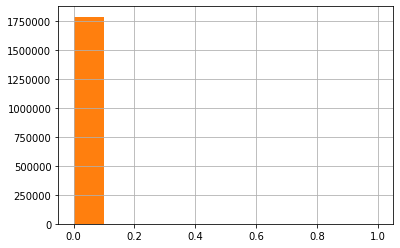

In [320]:
s1processed["Speed"].hist()
s0processed["Speed"].hist()

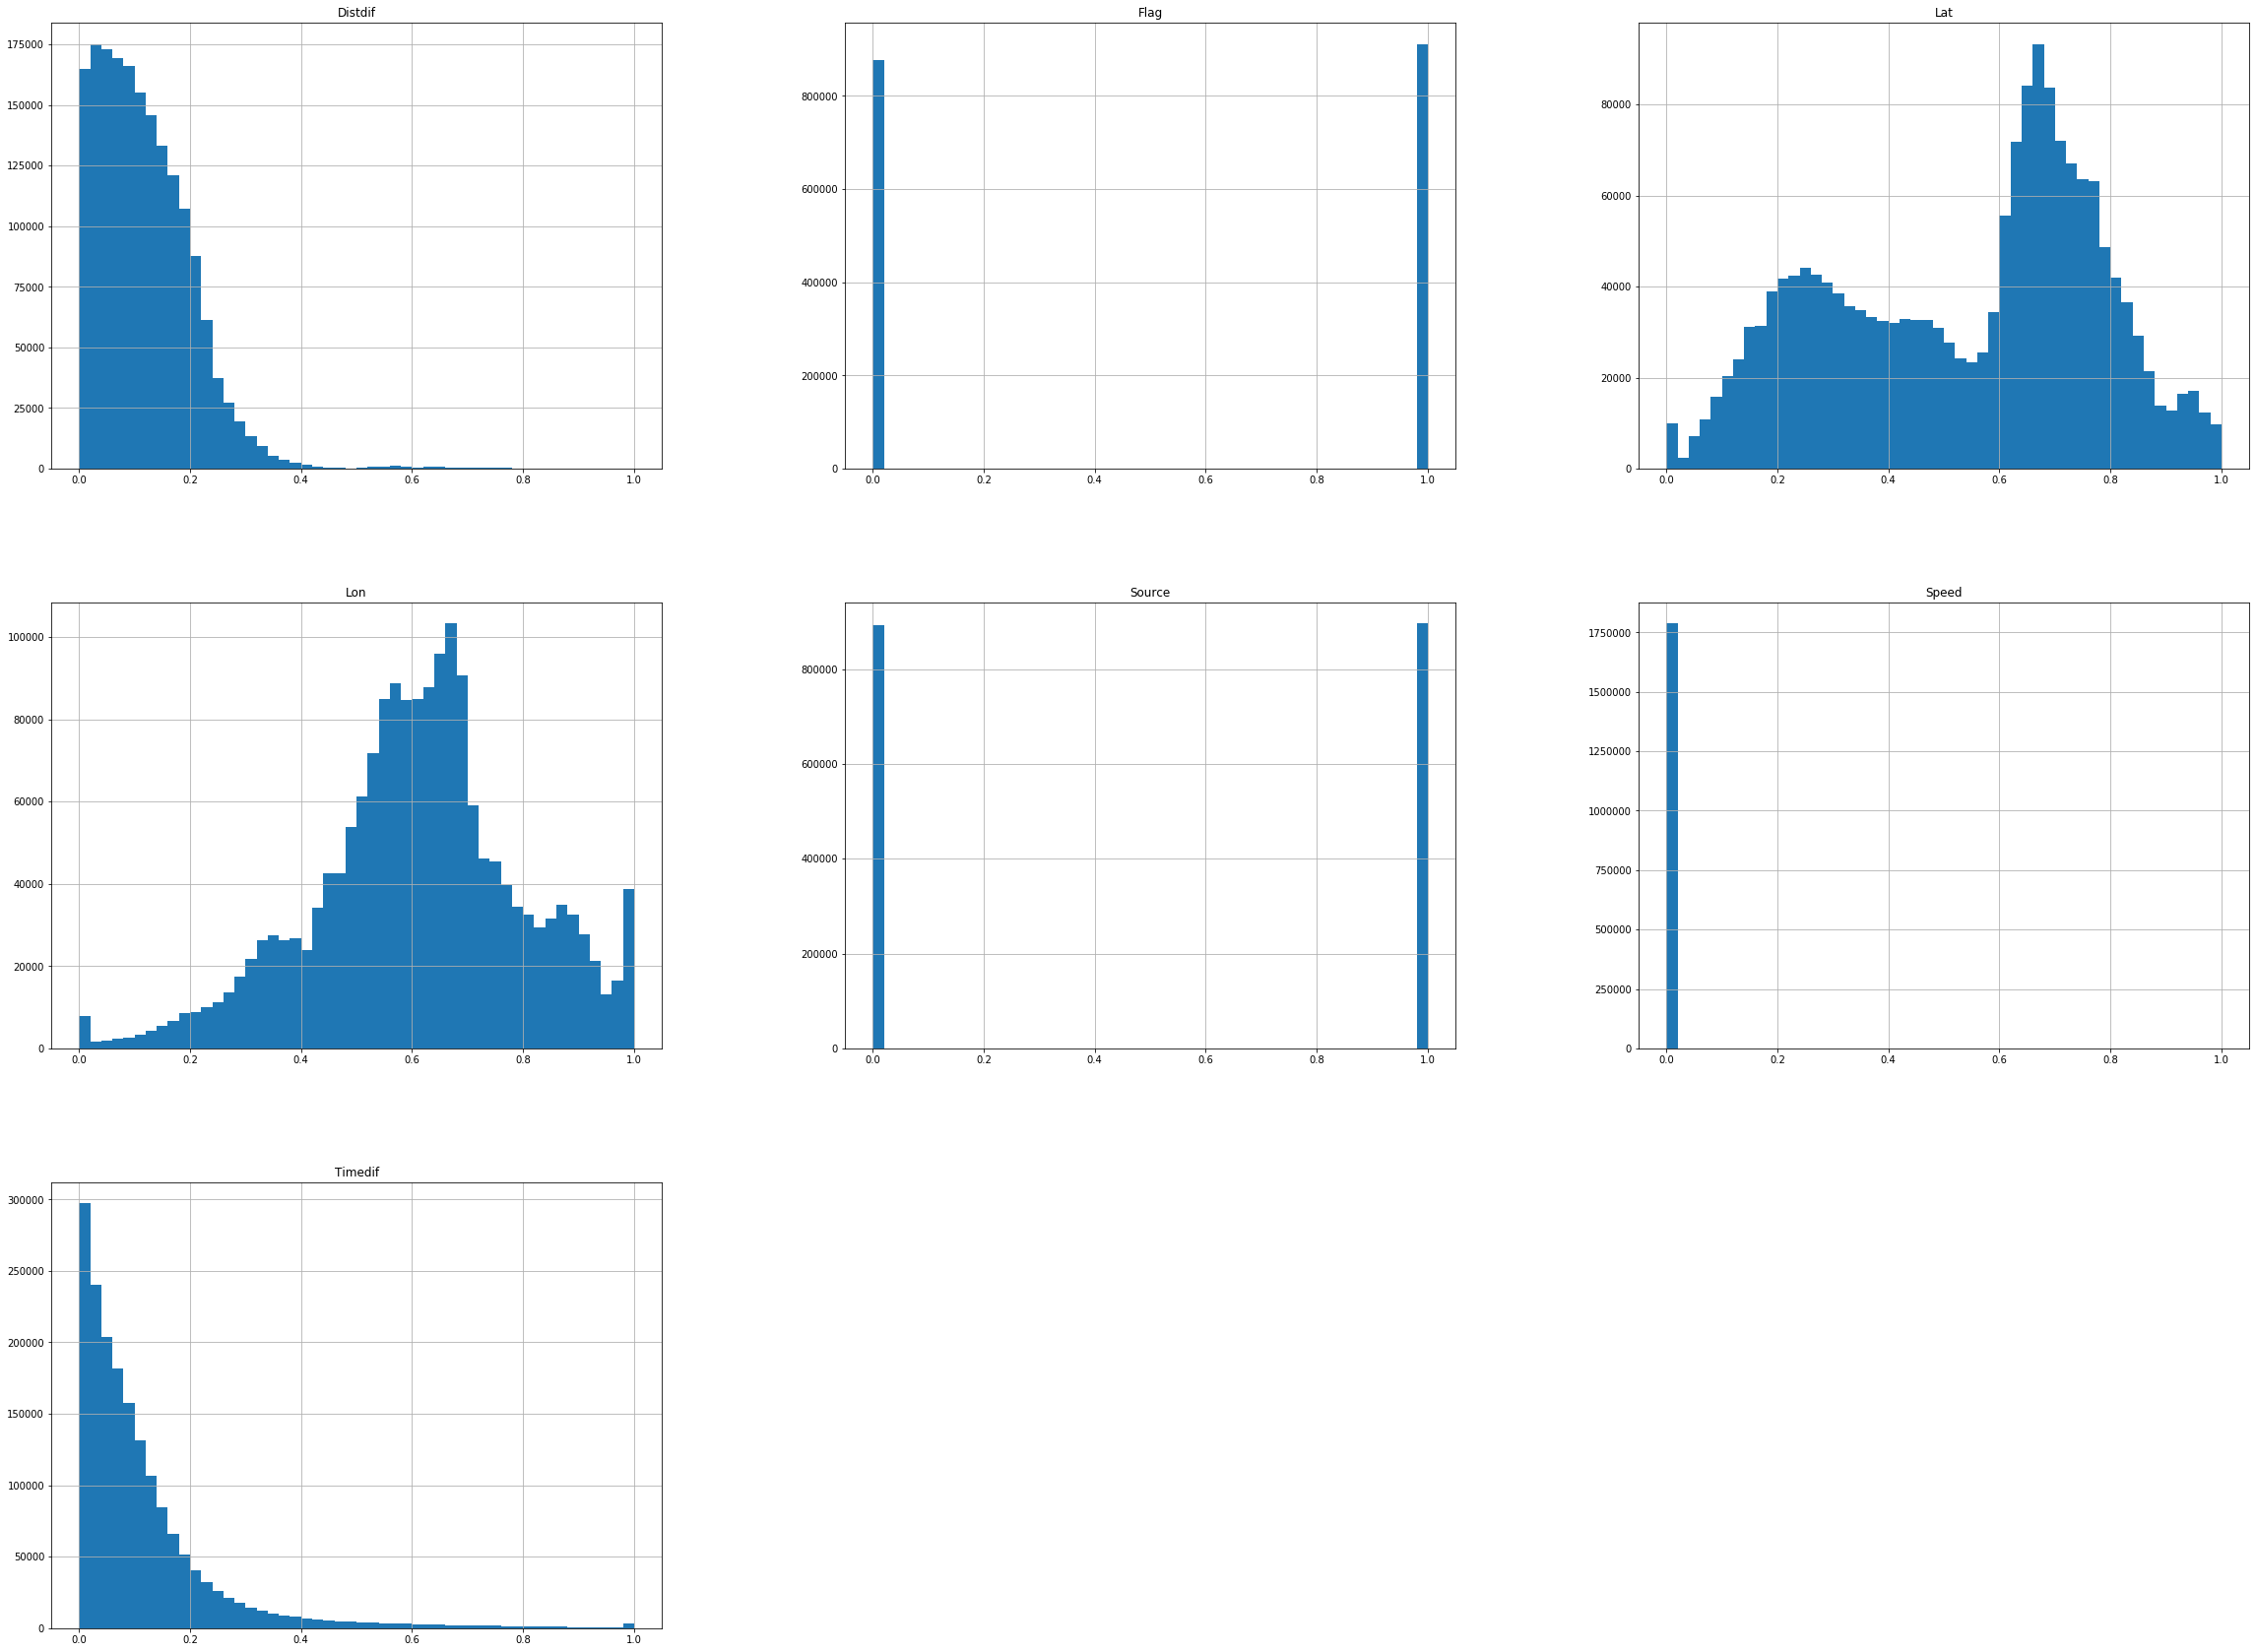

In [321]:
%matplotlib inline
import matplotlib.pyplot as plt

s0processed.hist(bins=50, figsize=(40, 30))
plt.show()

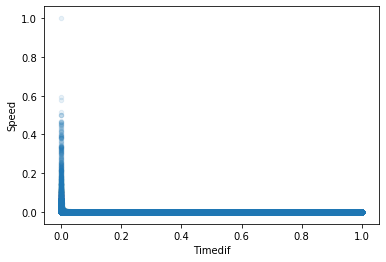

In [322]:
s0processed.plot(kind="scatter", x="Timedif", y="Speed", alpha=0.1)

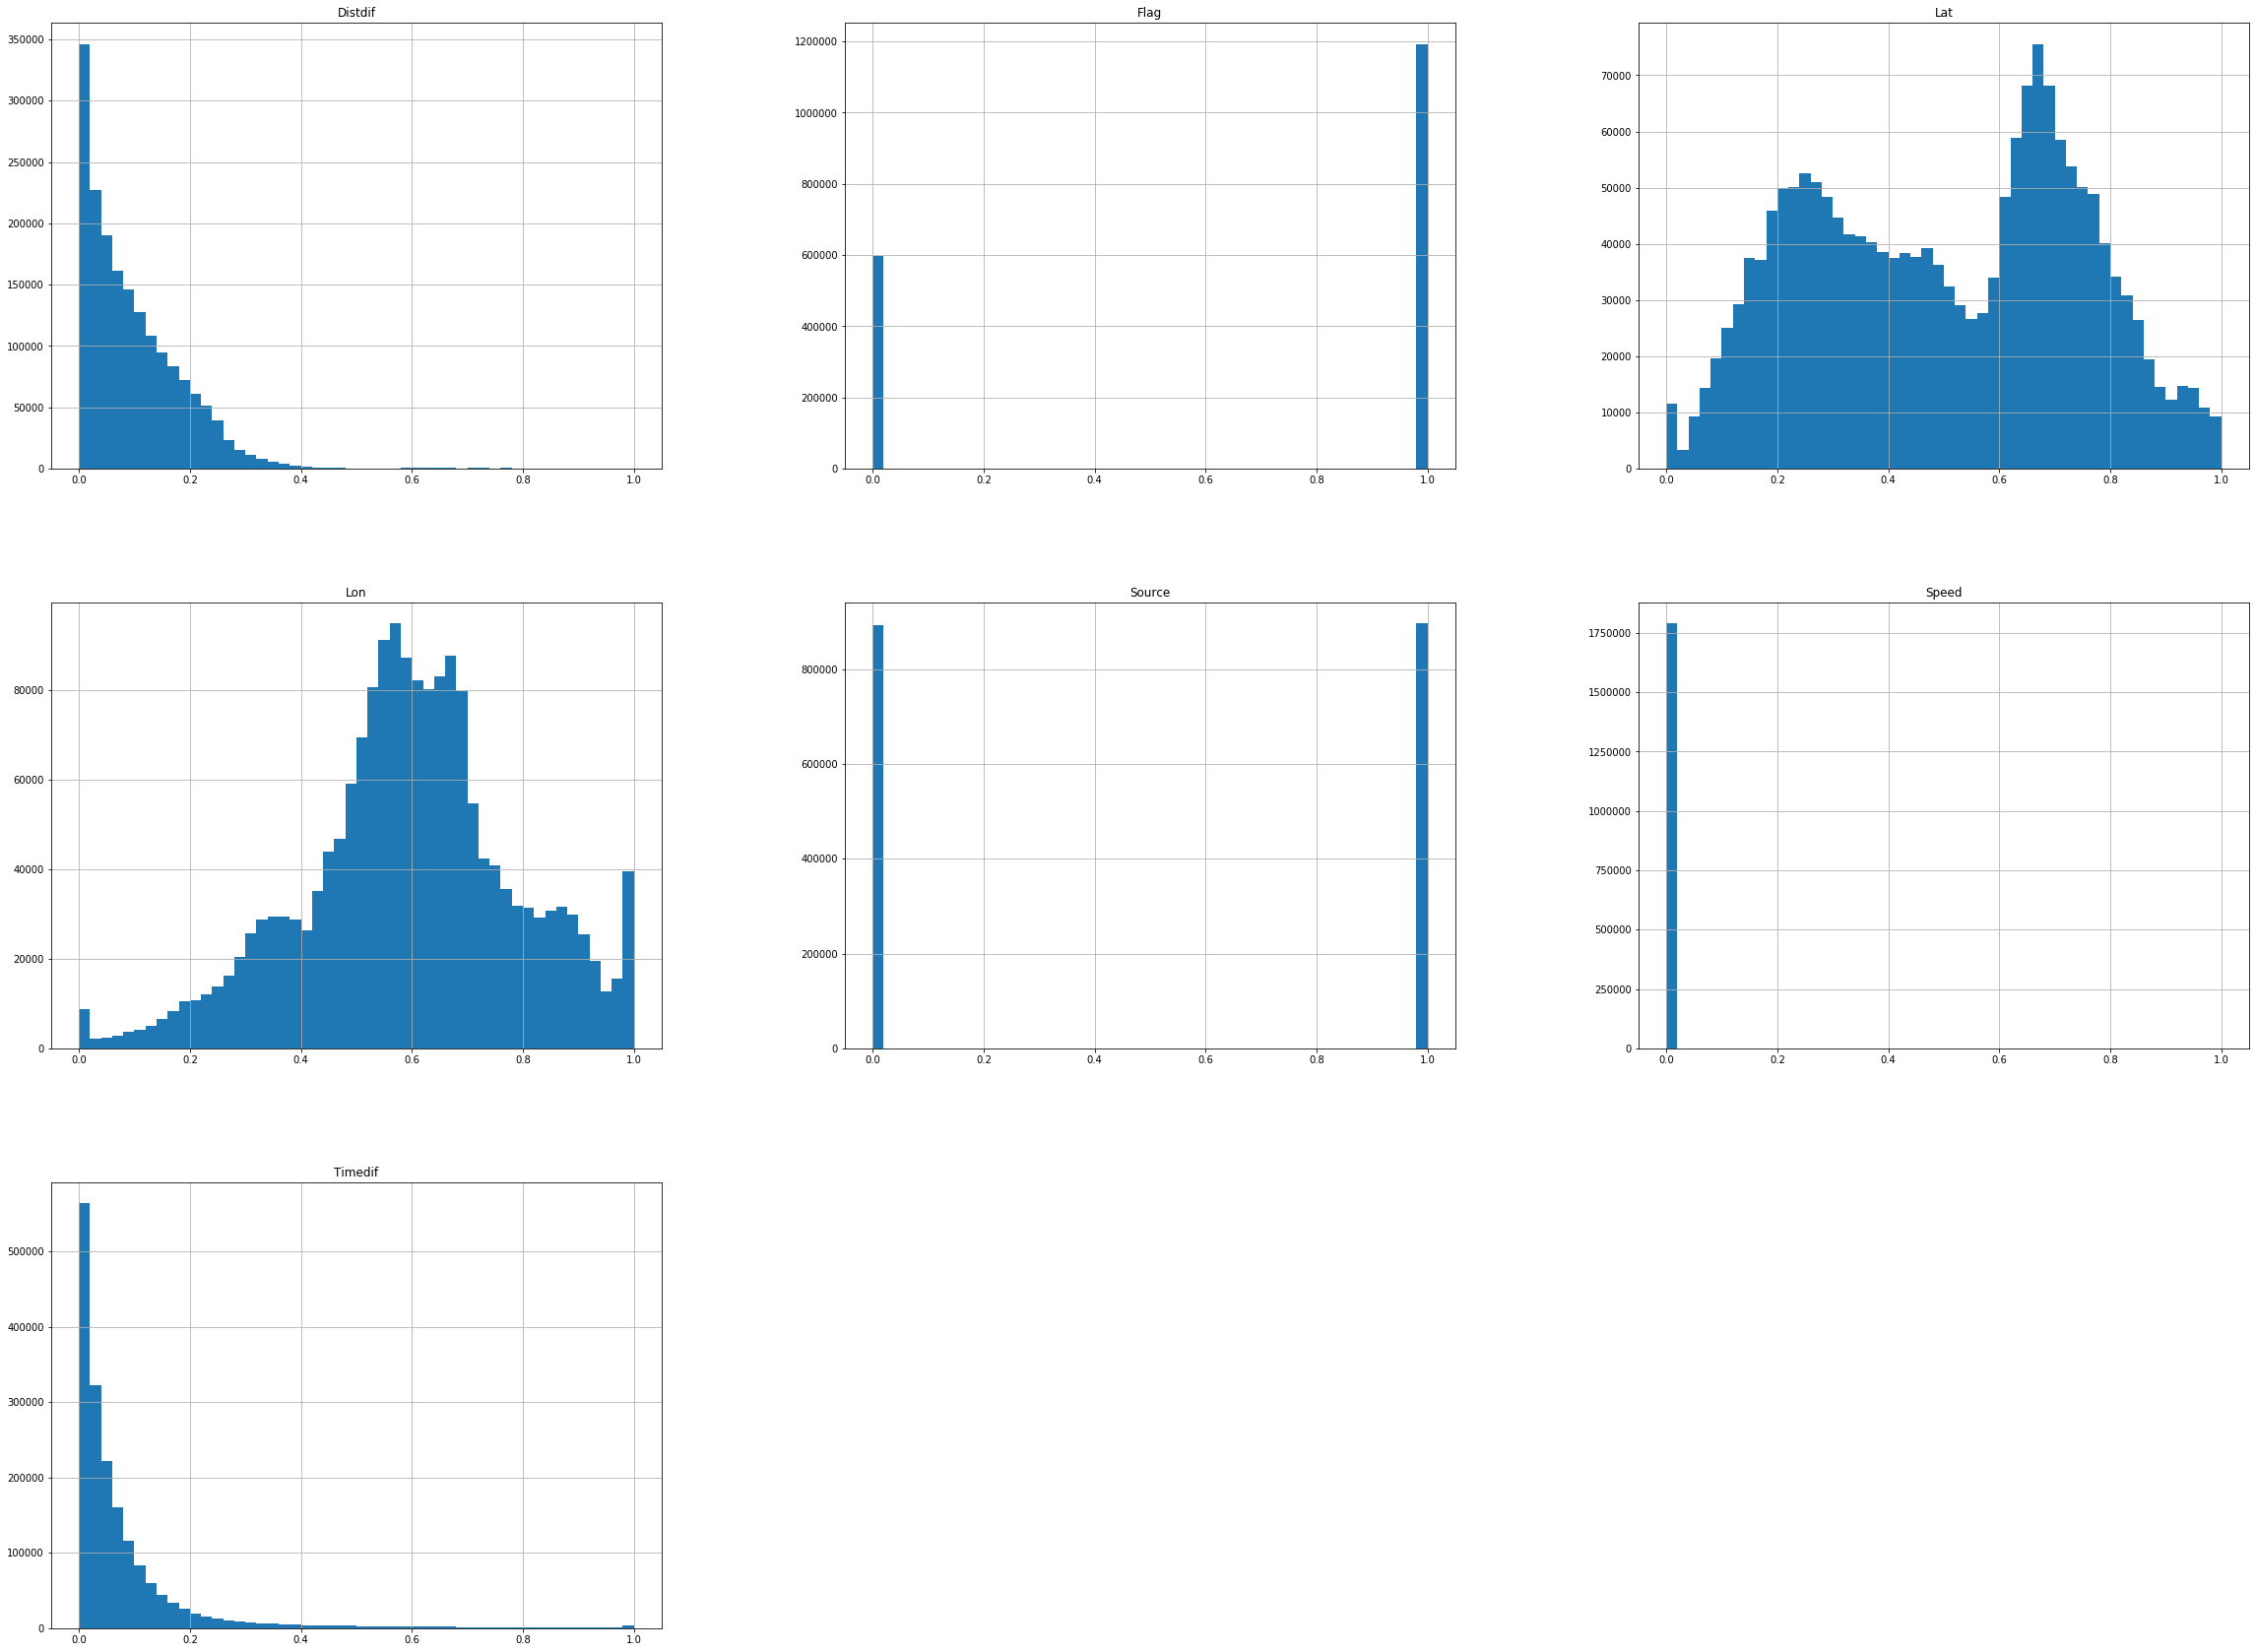

In [323]:
s1processed.hist(bins=50, figsize=(40, 30))
plt.show()

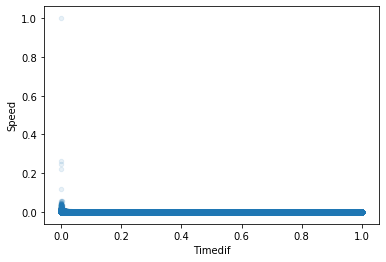

In [324]:
s1processed.plot(kind="scatter", x="Timedif", y="Speed", alpha=0.1)

In [327]:
corr_matrix1 = s1processed.corr()
corr_matrix0 = s0processed.corr()

In [326]:
corr_matrix1["Speed"].sort_values(ascending=False)

Speed      1.000000
Distdif    0.071219
Flag       0.021299
Lat        0.005746
Lon       -0.004946
Source    -0.020708
Timedif   -0.050751
Name: Speed, dtype: float64

In [328]:
corr_matrix0["Speed"].sort_values(ascending=False)

Speed      1.000000
Distdif    0.053760
Flag       0.053283
Lat        0.003402
Source    -0.002011
Lon       -0.005697
Timedif   -0.048675
Name: Speed, dtype: float64

In [329]:
np.savetxt('s1processed.txt', s1processed.values, delimiter=',')
np.savetxt('s0processed.txt', s0processed.values, delimiter=',')

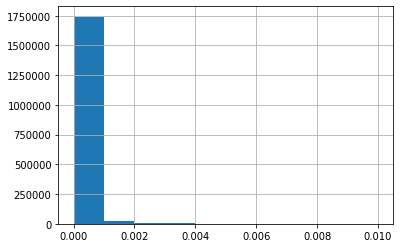

In [330]:
s0processed["Speed"].hist(range=(0,0.01))

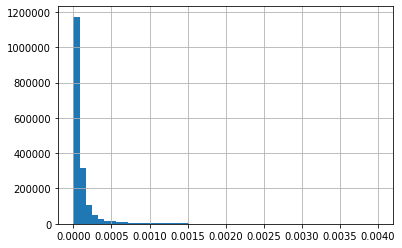

In [331]:
s0processed["Speed"].hist(range=(0,0.004), bins=50)

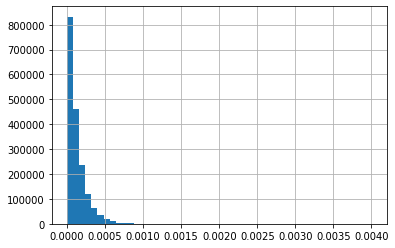

In [332]:
s1processed["Speed"].hist(range=(0,0.004), bins=50)